In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 717.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.2 MB/s eta 0:00:00


In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.transforms import NormalizeFeatures

In [3]:
# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

Processing...
Done!


In [141]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.6)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return self.log_softmax(x), x

In [142]:
# Initialize model, optimizer, and loss function
gcn_model = GCN(num_node_features=dataset.num_node_features, hidden_channels=16, num_classes=dataset.num_classes)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.NLLLoss()

In [143]:
# Take a look at model
print(gcn_model)

GCN(
  (conv1): GCNConv(1433, 16)
  (relu): ReLU()
  (dropout): Dropout(p=0.6, inplace=False)
  (conv2): GCNConv(16, 7)
  (log_softmax): LogSoftmax(dim=1)
)


In [144]:
# Define the training loop
def train(model):
    model.train()
    optimizer.zero_grad()
    out, embedding = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Define the test loop
def test(model):
    model.eval()
    out, embedding = model(data)
    _, pred = out.max(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc, embedding, pred

In [145]:
# Visualize embeddings
def visualize_embeddings(embedding, color, title):
    z = TSNE(n_components=2).fit_transform(embedding.detach().cpu().numpy())
    plt.figure(figsize=(10, 10))
    plt.scatter(z[:, 0], z[:, 1], c=color, cmap="coolwarm", s=100)
    plt.title(title)
    plt.show()

In [146]:
# Train the model and visualize the embeddings
for epoch in range(600):
    loss = train(gcn_model)
    if (epoch+1) % 30 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 029, Loss: 1.5531
Epoch: 059, Loss: 0.9603
Epoch: 089, Loss: 0.7245
Epoch: 119, Loss: 0.5251
Epoch: 149, Loss: 0.4417
Epoch: 179, Loss: 0.4118
Epoch: 209, Loss: 0.3995
Epoch: 239, Loss: 0.3293
Epoch: 269, Loss: 0.4061
Epoch: 299, Loss: 0.3126
Epoch: 329, Loss: 0.3000
Epoch: 359, Loss: 0.2914
Epoch: 389, Loss: 0.2615
Epoch: 419, Loss: 0.2832
Epoch: 449, Loss: 0.2240
Epoch: 479, Loss: 0.2553
Epoch: 509, Loss: 0.2514
Epoch: 539, Loss: 0.2397
Epoch: 569, Loss: 0.2515
Epoch: 599, Loss: 0.2318


In [147]:
acc, embedding, pred  = test(gcn_model)
print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.8130


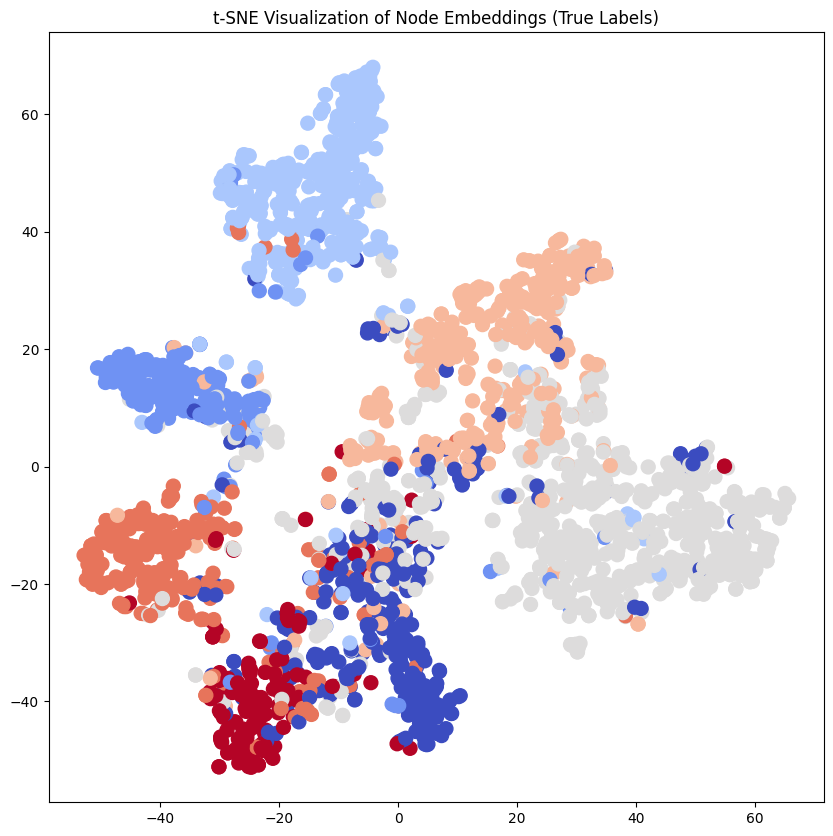

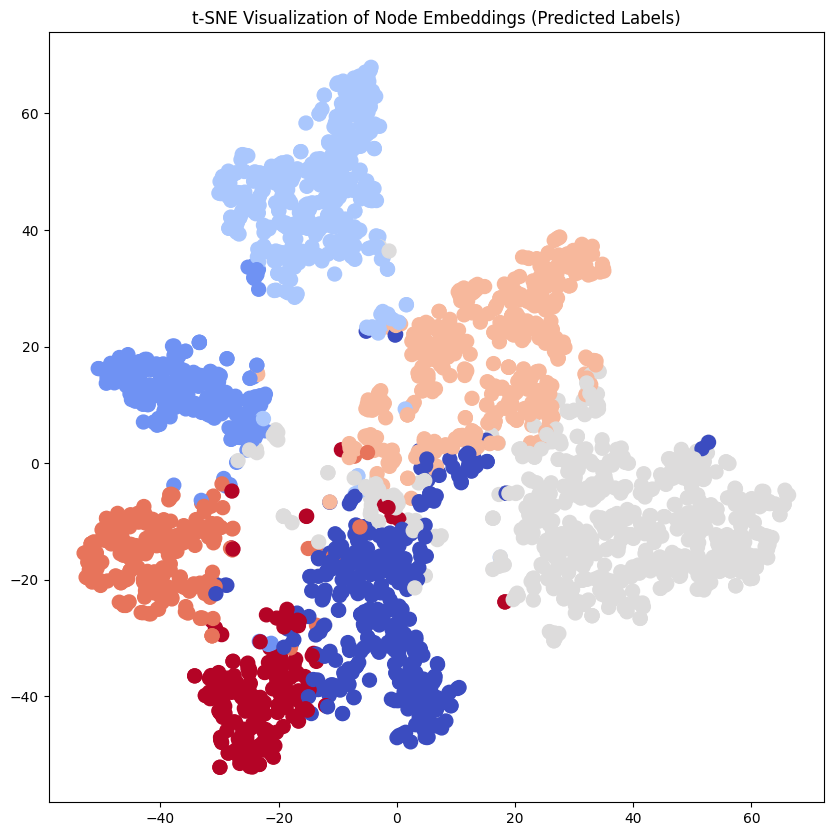

In [148]:
# Visualize the learned embeddings
visualize_embeddings(embedding, data.y, "t-SNE Visualization of Node Embeddings (True Labels)")
visualize_embeddings(embedding, pred, "t-SNE Visualization of Node Embeddings (Predicted Labels)")

In [174]:
class GAT(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, heads=8, dropout_rate=0.6):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=heads, dropout=dropout_rate)
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(0.5)
        self.conv2 = GATConv(hidden_channels * heads, num_classes, heads=1, concat=False, dropout=dropout_rate)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.elu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return self.log_softmax(x), x

In [175]:
# Initialize model, optimizer, and loss function
gat_model = GAT(num_node_features=dataset.num_node_features,
            hidden_channels=8,
            num_classes=dataset.num_classes,
            heads=8)
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.NLLLoss()

In [176]:
# Train the model and visualize the embeddings
for epoch in range(600):
    loss = train(gat_model)
    if (epoch+1) % 30 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 029, Loss: 1.5629
Epoch: 059, Loss: 1.1336
Epoch: 089, Loss: 0.8200
Epoch: 119, Loss: 0.6914
Epoch: 149, Loss: 0.7296
Epoch: 179, Loss: 0.6196
Epoch: 209, Loss: 0.5611
Epoch: 239, Loss: 0.5088
Epoch: 269, Loss: 0.5882
Epoch: 299, Loss: 0.5733
Epoch: 329, Loss: 0.5634
Epoch: 359, Loss: 0.5450
Epoch: 389, Loss: 0.5028
Epoch: 419, Loss: 0.5947
Epoch: 449, Loss: 0.5579
Epoch: 479, Loss: 0.5259
Epoch: 509, Loss: 0.5802
Epoch: 539, Loss: 0.5388
Epoch: 569, Loss: 0.4212
Epoch: 599, Loss: 0.5322


In [177]:
acc, embedding, pred = test(gat_model)
print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.8140


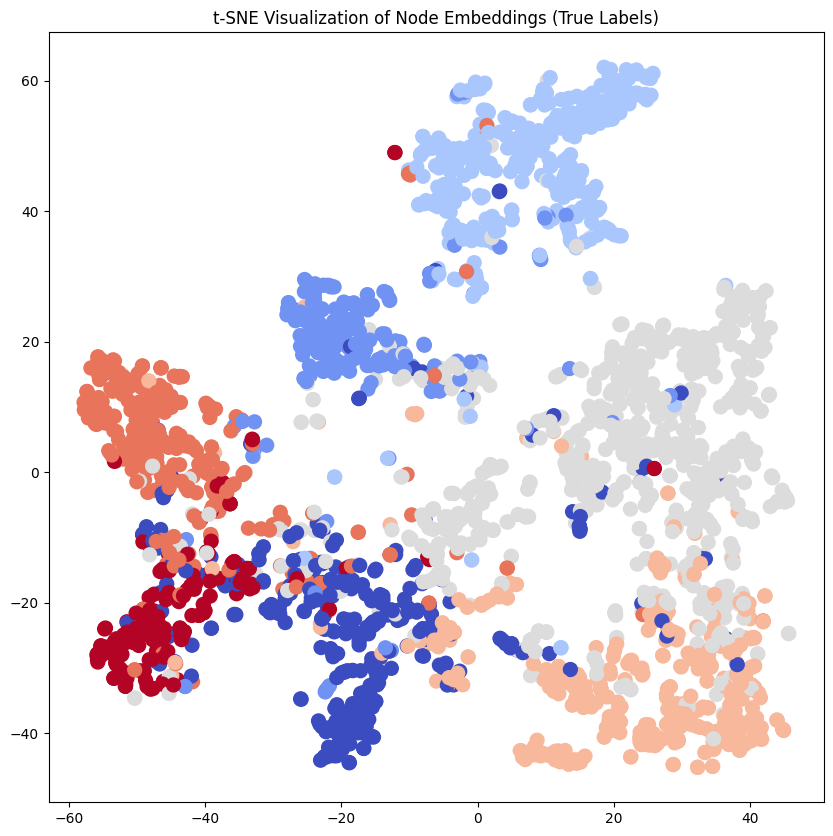

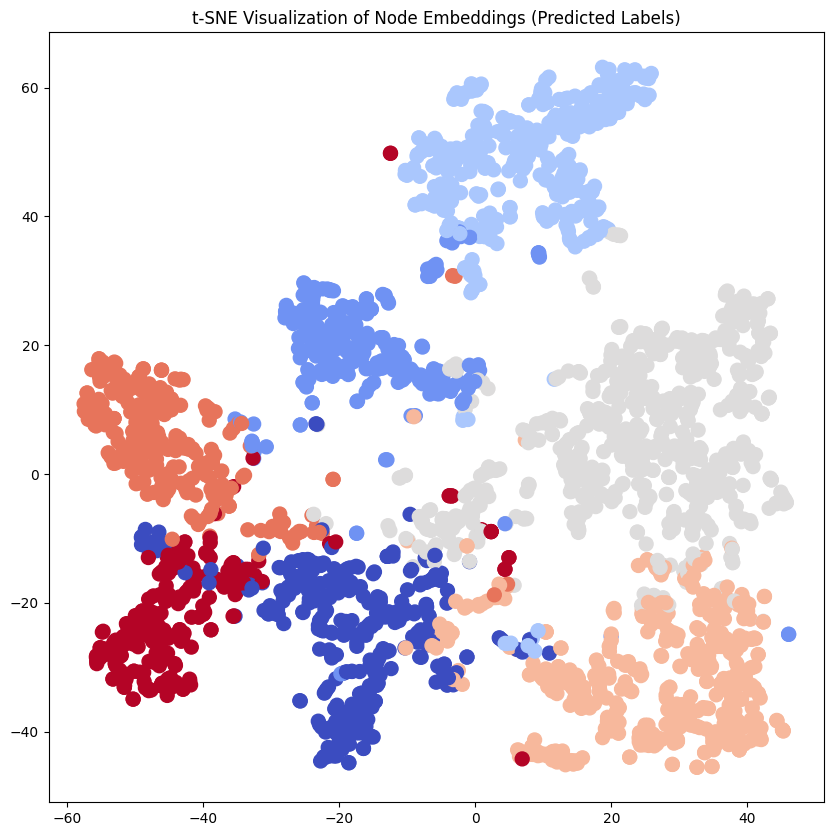

In [178]:
# Visualize the learned embeddings
visualize_embeddings(embedding, data.y, "t-SNE Visualization of Node Embeddings (True Labels)")
visualize_embeddings(embedding, pred, "t-SNE Visualization of Node Embeddings (Predicted Labels)")